## TODO:

- add variable names in diagram 
- write code to take simulation result csv as input and output another csv with the following columns:

run, statistic, sim_value, model_value, error

- objective 2
- objective 3
- objective 4

# Classless Analyitical Model

## Description

This is a classless modeling proposal of the webapp workflow case study proposed in the following book:
>  Performance Engineering Learning Through Applications Using JMT - Giuseppe Serazzi, chapter 6.3

In this proposal all jobs are serviced according to the following rules:
- Server B services all incoming jobs with class 1 service rate;
- Server P treats all incoming jobs with class 2 service rate;
- Server A treats all incoming jobs with a service rate averaged equally among classes.

## Queue Model

<!-- TODO: update diagram with parameters symbols -->
![basic queue network](../figs/webapp_conceptual.drawio.png)

In [114]:
from sympy import Idx, IndexedBase, Symbol
import sympy


print(f"using sympy {sympy.__version__}")

servers = ["A", "B", "P"]
classes = ["1", "2", "3"]

s = Idx("s")
"""
server index
"""
c = Idx("c")
"""
class index
"""
mu = IndexedBase("mu", shape=(len(servers), len(classes)))
"""
service rate of server s for jobs of class c
"""
p = IndexedBase("p", shape=(len(servers), len(classes)))
"""
probability that a job in service at server s is of class c
"""
gamma = Symbol("gamma")
"""
external mean arrival rate
"""
x = IndexedBase("X", shape=(len(servers)))
"""
throughput of server s
"""
e_t = IndexedBase("E[T]", shape=(len(servers)))
"""
expected response time (at server s, or global if omitted)
"""
e_n = IndexedBase("E[N]", shape=(len(servers)))
"""
expected job population (at server s, or global if omitted)
"""
v = IndexedBase("v", shape=(len(servers)))
"""
mean number of visits of a job to server s
"""
mu_s = IndexedBase("mu", shape=(len(servers)))
"""
mean service rate of server s without considering the job class
"""


service_rates = {
    "A": {
        "1": 1 / 0.2,
        "2": 1 / 0.4,
        "3": 1 / 0.1,
    },
    "B" : {
        "1": 1 / 0.8,
        "2": 0.0,
        "3": 0.0,
    },
    "P": {
        "1": 0.0,
        "2": 1 / 0.4,
        "3": 0.0,
    }
}

external_arrival_rates = [rate / 100.0 for rate in range(50, 125, 5)]

sympy.init_printing()

display(f"servers={servers}", f"classes={classes}")
display(f"service rates={service_rates}")
display(f"arrival rates={external_arrival_rates}")

using sympy 1.13.3


"servers=['A', 'B', 'P']"

"classes=['1', '2', '3']"

"service rates={'A': {'1': 5.0, '2': 2.5, '3': 10.0}, 'B': {'1': 1.25, '2': 0.0, '3': 0.0}, 'P': {'1': 0.0, '2': 2.5, '3': 0.0}}"

'arrival rates=[0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0, 1.05, 1.1, 1.15, 1.2]'

## Assumptions:

1) Server A treats all incoming jobs with a service rate averaged equally among classes.

We compute the service rate of server A assuming that all jobs are serviced with such rate, regardless of their class. Besides, we use an uniform distribution of job class probability.

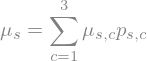

'----------------------------------'

In [100]:
from sympy import Eq, Sum, Symbol, Rational

# probability that a job of class c is in service at server s,
# given that a job is in service at server s
class_probabilities = {
    "A": {
        "1": Rational(1, 3),
        "2": Rational(1, 3),
        "3": Rational(1, 3),
    },
    "B": {
        "1": 1,
        "2": 0,
        "3": 0,
    },
    "P": {
        "1": 0,
        "2": 1,
        "3": 0,
    }
}

def get_mu_expr():
    return Sum(mu[s, c] * p[s, c], (c, classes[0], classes[-1]))

def get_mu_s_expr(index_s):
    mu_s_expr = Sum(mu[s, c] * p[s, c], (s, index_s, index_s), (c, 0, len(classes) - 1))
    return mu_s_expr

def calc_mu_s(server, class_probabilities, service_rates):
    
    index_s = server
    mu_s_expr = get_mu_s_expr(index_s)

    mu_s_expr = mu_s_expr.doit()
    mu_s_values = {}
    for cl in classes:
        index_c = classes.index(cl)
        mu_s_values.update({
            p[index_s, index_c]: class_probabilities[cl],
            mu[index_s, index_c]: service_rates[server][cl]
        })

    mu_s_res = mu_s_expr.subs(mu_s_values, simultaneous=True)
    display(Eq(mu_s[index_s], mu_s_res))
    return mu_s_res

display(Eq(mu_s[s], get_mu_expr()))
display("----------------------------------")

mu_a_val = calc_mu_s("A", class_probabilities["A"], service_rates)

# we can use same code to calc mu of other servers

mu_b_val = calc_mu_s("B", class_probabilities["B"], service_rates)
mu_p_val = calc_mu_s("P", class_probabilities["P"], service_rates)

mu_vals = {
    "A": mu_a_val,
    "B": mu_b_val,
    "P": mu_p_val
}

2) Job flow is balanced. Namely, no job is created/destroyed inside the system.

Using the above assumptions we can compute local arrival rates at each node of the network

'flow balance for A:'

'flow balance for B:'

'flow balance for P:'

'flow balance system:'

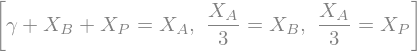

'using class probabilities:'

{'A': {'1': 1/3, '2': 1/3, '3': 1/3},
 'B': {'1': 1, '2': 0, '3': 0},
 'P': {'1': 0, '2': 1, '3': 0}}

'solve for throughputs'

'----------------------------------'

In [128]:
from sympy import Eq, Expr, IndexedBase, solve

lambda_ = IndexedBase("lambda", shape=(len(servers)))

lambda_a = Eq(lambda_["A"], gamma + x["B"] + x["P"])
lambda_b = Eq(lambda_["B"], x["B"])
lambda_p = Eq(lambda_["P"], x["P"])

lambdas = {
    "A": lambda_a,
    "B": lambda_b,
    "P": lambda_p,
}

for server in servers:
    display(lambdas[server])

# solve flow balance linear system of equations
flow_balance_a = Eq(gamma + x["B"] + x["P"], Sum(x[s] * p[s, c], (s, "A", "A"), (c, "1", "3")).doit())
display("flow balance for A:", flow_balance_a)
flow_balance_b = Eq(x["A"] * p["A","1"], x["B"])
display("flow balance for B:", flow_balance_b)
flow_balance_p = Eq(x["A"] * p["P", "2"], x["P"])
display("flow balance for P:", flow_balance_p)

flow_balance_eqs = [
    flow_balance_a,
    flow_balance_b,
    flow_balance_p,
]

for i in range(len(flow_balance_eqs)):
    for cl in classes:
        for server in servers:
            index_c = classes.index(cl)
            flow_balance_eqs[i] = flow_balance_eqs[i].doit().subs(p[server, cl], class_probabilities["A"][cl])

display("flow balance system:", flow_balance_eqs)

throughputs = solve(flow_balance_eqs, x["A"], x["B"], x["P"])
display("using class probabilities:", class_probabilities)
display("solve for throughputs", throughputs)

lambda_exprs = {
    "A": gamma + throughputs[x["B"]] + throughputs[x["P"]],
    "B": throughputs[x["B"]],
    "P": throughputs[x["P"]],
}

display("----------------------------------")
for server in servers:
    display(Eq(lambda_[server], lambda_exprs[server]))


## Objective 1

We check for system stability for each arrival rate used in the experiment

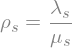

'Searching for stable system configurations ...'

'----------------------------------'

'----------------------------------'

'----------------------------------'

'----------------------------------'

'----------------------------------'

'----------------------------------'

'----------------------------------'

'----------------------------------'

'----------------------------------'

'----------------------------------'

'----------------------------------'

'----------------------------------'

'----------------------------------'

'----------------------------------'

'----------------------------------'

In [98]:
def is_stable(rho_values):
    for value in rho_values:
        if value >= 1:
            return False
    return True

rho = IndexedBase("rho", shape=(len(servers)))

def display_rho():
    mu_s = Symbol(f"mu_s")
    display(Eq(rho[s], lambda_[s] / mu_s))

# for server in servers:
display_rho()

display("Searching for stable system configurations ...")

rho_values = {}
stable_rates = []

for rate in external_arrival_rates:

    rho_values_per_server = {}
    
    for server in servers:

        index_s = server

        mu_s_expr = get_mu_s_expr(index_s)
        mu_s_expr = mu_s_expr.doit().subs({p[index_s, classes.index(cl)]: class_probabilities[server][cl] for cl in classes}, simultaneous=True)
        mu_s_expr = mu_s_expr.subs({mu[index_s, classes.index(cl)]: service_rates[server][cl] for cl in classes}, simultaneous=True)
        rho_expr = lambda_[index_s] / mu_s_expr
        rho_expr = rho_expr.subs(lambda_[index_s], lambda_exprs[server])
        rho_expr = rho_expr.subs(gamma, rate)

        rho_values_per_server[server] = rho_expr
        
    if is_stable(rho_values_per_server.values()):
        
        stable_rates.append(rate)
        rho_values[rate] = rho_values_per_server
        display("----------------------------------")
        display(Eq(gamma, rate))
        for server in servers:
            display(Eq(rho[server], rho_values_per_server[server]))


### Local perfomances
We assume a Processor Sharing (PS) queue policy for each server, since this is the policy used in the case study.

Throughputs have already been computed when solving the queue network

N is computed using Little's Law.

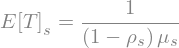

'----------------------------------'

'----------------------------------'

'----------------------------------'

'----------------------------------'

'----------------------------------'

'----------------------------------'

'----------------------------------'

'----------------------------------'

'----------------------------------'

'----------------------------------'

'----------------------------------'

'----------------------------------'

'----------------------------------'

'----------------------------------'

'----------------------------------'

In [131]:
e_t_values = {}

for rate in stable_rates:
    e_t_values[rate] = {}

e_t_expr = 1 / (mu_s[s] * (1 - rho[s]))
display(Eq(e_t[s], e_t_expr))

e_n_expr = lambda_[s] * e_t[s]
display(Eq(e_n[s], e_n_expr))

display(throughputs)

for rate in rho_values.keys():
    display("----------------------------------")
    display(Eq(gamma, rate))
    for server in servers:
        
        # response time
        mu_s_expr = get_mu_s_expr(server).doit().subs({mu[server, cl]: service_rates[server][cl] for cl in classes}, simultaneous=True)
        mu_s_val = mu_vals[server]
        rho_val = rho_values[rate][server]
        e_t_val = e_t_expr.subs({
            mu_s[s]: mu_s_val,
            rho[s]: rho_val
        }).doit()
        display(Eq(e_t[server], e_t_val))
        e_t_values[rate][server] = e_t_val

        # throughput
        display(Eq(x[server], throughputs[x[server]].subs(gamma, rate)))

        # mean population
        lambda_expr = lambda_exprs[server].subs(gamma, rate)
        e_n_val = e_n_expr.subs({
            lambda_[s]: lambda_expr,
            e_t[s]: e_t_val
        })
        display(Eq(e_n[server], e_n_val))
        


### Global Performances

We have to consider mean job visits to each node in order to compute the global mean response time.

Global throughput is given by external arrival rate $\gamma$ in each stable configuration.

Once again, we can leverage little to compute the global mean population.

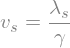

'----------------------------------'

'----------------------------------'

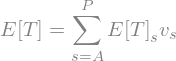

'----------------------------------'

'----------------------------------'

'----------------------------------'

'----------------------------------'

'----------------------------------'

'----------------------------------'

'----------------------------------'

'----------------------------------'

'----------------------------------'

'----------------------------------'

'----------------------------------'

'----------------------------------'

'----------------------------------'

'----------------------------------'

'----------------------------------'

In [156]:
v_expr = lambda_[s] / gamma
display(Eq(v[s], v_expr))
display("----------------------------------")
for server in servers:
    display(Eq(v[server], (v_expr).subs({
        lambda_[s]: lambda_exprs[server],
    })))
display("----------------------------------")
display(Eq(e_t, Sum(v[s] * e_t[s], (s, servers[0], servers[-1]))))
display(Eq(e_n, gamma * e_t))
x_expr = x["A"] * p["A", "3"]
display(Eq(x, x_expr))

for rate in stable_rates:
    display("----------------------------------")
    
    # Response time
    display(Eq(gamma, rate))
    e_t_global_expr = Sum(v[s] * e_t[s], (s, 0, len(servers) - 1)).doit()
    for server in servers:
        index_s = servers.index(server)
        v_s_expr = v_expr.subs(lambda_[s], lambda_exprs[server])
        e_t_global_expr = e_t_global_expr.subs({
            v[index_s]: v_s_expr,
            e_t[index_s]: e_t_values[rate][server],
        })
    display(Eq(e_t, e_t_global_expr))

    # Population
    e_n_global_expr = gamma * e_t_global_expr
    e_n_global_expr = e_n_global_expr.subs(gamma, rate)
    display(Eq(e_n, e_n_global_expr))

    # Throughput
    x_val = x_expr.subs({
        x["A"]: throughputs[x["A"]],
        gamma: rate,
        p["A", "3"]: class_probabilities["A"]["3"]
    })
    display(Eq(x, x_val))
        